In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.base import BaseEstimator, ClassifierMixin




In [2]:
df = pd.read_csv("smoking_driking_dataset_Ver01.csv.gz")

In [3]:
df

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991341,Male,45,175,80,92.1,1.5,1.5,1.0,1.0,114.0,...,125.0,132.0,15.0,1.0,1.0,26.0,36.0,27.0,1.0,N
991342,Male,35,170,75,86.0,1.0,1.5,1.0,1.0,119.0,...,84.0,45.0,15.8,1.0,1.1,14.0,17.0,15.0,1.0,N
991343,Female,40,155,50,68.0,1.0,0.7,1.0,1.0,110.0,...,77.0,157.0,14.3,1.0,0.8,30.0,27.0,17.0,3.0,Y
991344,Male,25,175,60,72.0,1.5,1.0,1.0,1.0,119.0,...,73.0,53.0,14.5,1.0,0.8,21.0,14.0,17.0,1.0,N


# Data Preparation
## Check for Missing Values

In [4]:
df.isnull().sum()

sex                 0
age                 0
height              0
weight              0
waistline           0
sight_left          0
sight_right         0
hear_left           0
hear_right          0
SBP                 0
DBP                 0
BLDS                0
tot_chole           0
HDL_chole           0
LDL_chole           0
triglyceride        0
hemoglobin          0
urine_protein       0
serum_creatinine    0
SGOT_AST            0
SGOT_ALT            0
gamma_GTP           0
SMK_stat_type_cd    0
DRK_YN              0
dtype: int64

# Data Processing

## Converting categorical columns into 0 and 1

In [5]:
df.head(5)

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N


In [6]:
df["sex"] = (df["sex"] == "Male").astype(int)
df["DRK_YN"] = (df["DRK_YN"] == "Y").astype(int)

In [7]:
X = df.drop("DRK_YN", axis = 1)
y = df["DRK_YN"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8,shuffle = True, random_state = 42)

In [9]:
print(X.memory_usage(deep=True).sum() + y.memory_usage(deep=True))

190338696


In [26]:
class Logistic(BaseEstimator, ClassifierMixin):
    
    def __init__(self, learning_rate = 1000, alpha = 0.01):
        self.learning_rate = learning_rate
        self.alpha = alpha
              
        
        
    def fit(self, X, y):
        
       
        self.cost_list = []
        self.ite_list = []
        self.theta_history = []
        
        X = np.c_[X, np.ones(X.shape[0])]
        self.theta = np.zeros(X.shape[1])
        m = len(X)
        
        for i in range(self.learning_rate):
        
            z = np.dot(X, self.theta)
            h_x = 1/(1+np.exp(-z))
            epsilon = 1e-15

            J_theta = (-1/m)*np.sum((y * np.log(h_x + epsilon)) + ((1-y)* np.log(1 - h_x + epsilon)))

            grad_theta = (1/m)*np.dot(X.T, (h_x - y))

            self.theta -= self.alpha * grad_theta
            
            self.cost_list.append(J_theta) 
            self.theta_history.append(self.theta.copy())  
            
            
        return self
    
    def predict(self, X):
        
        X = np.c_[X, np.ones(X.shape[0])]
        
        z = np.dot(X, self.theta)
        h_x = 1/(1+ np.exp(-z))
        
        return ((h_x >= 0.5)).astype(int)
              

In [10]:
pipeline = Pipeline([
    ('standardising', StandardScaler()),
    ('mode', Logistic(1000, 0.01))
])

In [11]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardising', StandardScaler()), ('mode', Logistic())])

In [12]:
param_grid = {
    "learning_rate": [500,1000,1500,2000,2500],
    "alpha" : [0.1,0.01,0.001]
}

In [15]:
def gridsearch(pipeline, X, y, param_grid, cv = 5):
    best_score = -np.inf
    best_params = None
    results = []
    
    
    kf = KFold(cv, shuffle = True, random_state = 42)

    for al in param_grid["alpha"]:
        for lr in param_grid["learning_rate"]:
            scores = []

    
            for train_index, test_index in kf.split(X):
            
                X_train, X_val = X.iloc[train_index], X.iloc[test_index]
                y_train, y_val = y.iloc[train_index], y.iloc[test_index]
                
                pipeline.set_params(   
                    mode__alpha = al,
                    mode__learning_rate = lr   
                )
                
                pipeline.fit(X_train, y_train)
                
                y_pred = pipeline.predict(X_val)  
                
                scores.append(np.mean(y_pred == y_val))
                
            mean_score = np.mean(scores)
            results.append((lr, al, mean_score))
            
                
            if mean_score >= best_score:
                best_score = mean_score
                    
                best_params = {
                    "alpha" : al,
                    "learning_rate": lr
                }
                    
    return best_params, results, best_score
                
        
        

In [16]:
X_subset, _, y_subset, _ = train_test_split(X_train, y_train, train_size=0.2, random_state=42)

In [17]:
best_params, results, best_score = gridsearch(pipeline, X_subset, y_subset, param_grid, cv = 5) 

In [18]:
best_params

{'alpha': 0.1, 'learning_rate': 2500}

In [19]:
results

[(500, 0.1, 0.7263310531790814),
 (1000, 0.1, 0.7268543328184599),
 (1500, 0.1, 0.7269741197238597),
 (2000, 0.1, 0.7270497746114806),
 (2500, 0.1, 0.727056079185449),
 (500, 0.01, 0.71373451439019),
 (1000, 0.01, 0.7198310374176465),
 (1500, 0.01, 0.722472653910412),
 (2000, 0.01, 0.7239920562367999),
 (2500, 0.01, 0.7245720770418939),
 (500, 0.001, 0.7015351637613089),
 (1000, 0.001, 0.7027582511111812),
 (1500, 0.001, 0.7047126690413896),
 (2000, 0.001, 0.7062320713677772),
 (2500, 0.001, 0.707474072439555)]

In [20]:
best_score

0.727056079185449

# Best Params:

{'alpha': 0.1, 'learning_rate': 2500}



[(500, 0.1, 0.7263310531790814),
 (1000, 0.1, 0.7268543328184599),
 (1500, 0.1, 0.7269741197238597),
 (2000, 0.1, 0.7270497746114806),
 (2500, 0.1, 0.727056079185449),
 (500, 0.01, 0.71373451439019),
 (1000, 0.01, 0.7198310374176465),
 (1500, 0.01, 0.722472653910412),
 (2000, 0.01, 0.7239920562367999),
 (2500, 0.01, 0.7245720770418939),
 (500, 0.001, 0.7015351637613089),
 (1000, 0.001, 0.7027582511111812),
 (1500, 0.001, 0.7047126690413896),
 (2000, 0.001, 0.7062320713677772),
 (2500, 0.001, 0.707474072439555)]

In [27]:
pipeline.set_params(mode = Logistic(learning_rate = 2500, alpha = 0.1))

Pipeline(steps=[('standardising', StandardScaler()),
                ('mode', Logistic(alpha=0.1, learning_rate=2500))])

In [28]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardising', StandardScaler()),
                ('mode', Logistic(alpha=0.1, learning_rate=2500))])

# contour plot

In [41]:
def plot_contour_and_path(X, y, logistic_model):
    """
    Plot the contour of the cost function and the gradient descent path.

    Parameters:
        X (numpy.ndarray): Feature matrix with two features.
        y (numpy.ndarray): Target vector.
        logistic_model: Trained Logistic regression model.
    """
    # Add bias term to X
    X = np.c_[X, np.ones(X.shape[0])]

    # Generate grid of theta0 and theta1
    theta0_vals = np.linspace(-1, 1, 100)
    theta1_vals = np.linspace(-1, 1, 100)
    theta0_grid, theta1_grid = np.meshgrid(theta0_vals, theta1_vals)

    # Compute cost for each combination of theta0 and theta1
    costs = np.zeros_like(theta0_grid)
    for i in range(theta0_grid.shape[0]):
        for j in range(theta0_grid.shape[1]):
            # Create theta vector with two variables and bias term
            theta = np.array([theta0_grid[i, j], theta1_grid[i, j], logistic_model.theta[-1]])
            z = np.dot(X, theta)
            h_x = 1 / (1 + np.exp(-z))
            epsilon = 1e-15
            costs[i, j] = (-1 / len(y)) * np.sum(
                y * np.log(h_x + epsilon) + (1 - y) * np.log(1 - h_x + epsilon)
            )

    # Plot contour 
    plt.figure(figsize=(10, 6))
    cp = plt.contourf(theta0_vals, theta1_vals, costs, levels=50, cmap="viridis")
    plt.colorbar(cp)
    plt.title("Cost Function Contour and Gradient Descent Path")
    plt.xlabel(r"$\theta_0$")
    plt.ylabel(r"$\theta_1$")

    # Overlay gradient descent path
    theta_history = np.array(logistic_model.theta_history)
    plt.plot(theta_history[:, 0], theta_history[:, 1], 'r-o', label="Gradient Descent Path")
    plt.legend()
    plt.show()


In [30]:
logistic_model = pipeline.named_steps['mode']


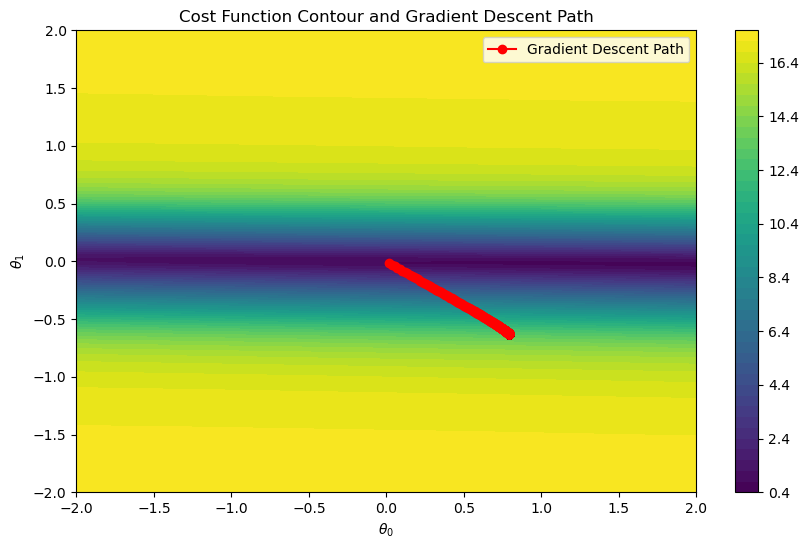

In [36]:
X_subset = X_train.iloc[:, :2]  # Use the first two features
y_subset = y_train

# Train the pipeline
pipeline.set_params(mode=Logistic(learning_rate=1000, alpha=0.1))
pipeline.fit(X_subset.to_numpy(), y_subset.to_numpy())

# Extract logistic model
logistic_model = pipeline.named_steps['mode']

# Plot the contour and gradient descent path



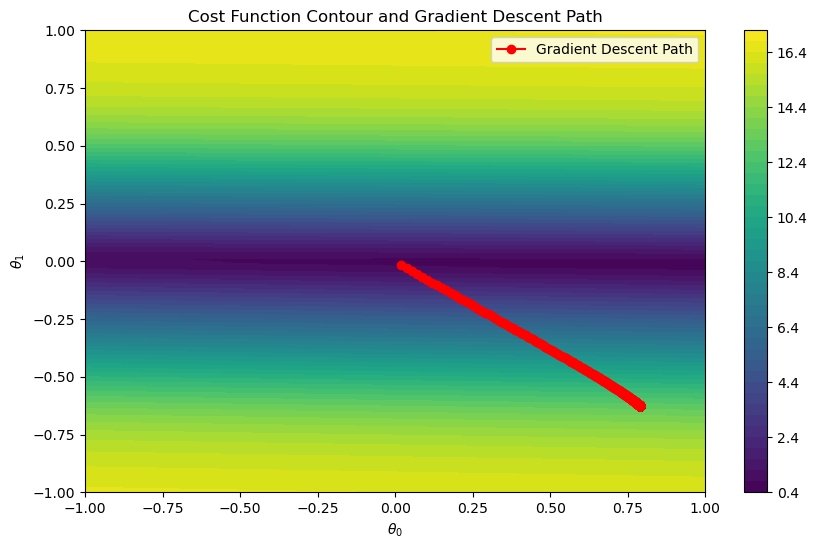

In [42]:
plot_contour_and_path(X_subset.to_numpy(), y_subset.to_numpy(), logistic_model)

# Now fit the model again on the train data using best params

In [43]:
pipeline.set_params(mode = Logistic(alpha = 0.1, learning_rate = 2500))

Pipeline(steps=[('standardising', StandardScaler()),
                ('mode', Logistic(alpha=0.1, learning_rate=2500))])

In [44]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardising', StandardScaler()),
                ('mode', Logistic(alpha=0.1, learning_rate=2500))])

# Accuracy

In [45]:
pipeline.score(X_test, y_test)

0.7248297775760327

# Now implementing with Pyspark

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
import numpy as np
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline

In [15]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("LogisticRegressionWithPySpark") \
    .config("spark.driver.host", "127.0.0.1") \
    .getOrCreate()

In [16]:
df = spark.read.csv("smoking_driking_dataset_Ver01.csv.gz", header=True, inferSchema=True)

# Preprocess Data (Converting categorical columns)
df = df.withColumn("sex", (col("sex") == "Male").cast("int"))
df = df.withColumn("DRK_YN", (col("DRK_YN") == "Y").cast("int"))


In [17]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Convert PySpark DataFrame to NumPy arrays for logistic regression
X_train = np.array(train_data.select([col for col in df.columns if col != "DRK_YN"]).collect())
y_train = np.array(train_data.select("DRK_YN").collect()).flatten()
X_test = np.array(test_data.select([col for col in df.columns if col != "DRK_YN"]).collect())
y_test = np.array(test_data.select("DRK_YN").collect()).flatten()


In [18]:
class Logistic(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=1000, alpha=0.01):
        self.learning_rate = learning_rate
        self.alpha = alpha

    def fit(self, X, y):
        self.cost_list = []
        self.theta_history = []

        X = np.c_[X, np.ones(X.shape[0])]  # Add bias term
        self.theta = np.zeros(X.shape[1])
        m = len(X)

        for i in range(self.learning_rate):
            z = np.dot(X, self.theta)
            h_x = 1 / (1 + np.exp(-z))
            epsilon = 1e-15
            J_theta = (-1 / m) * np.sum(
                (y * np.log(h_x + epsilon)) + ((1 - y) * np.log(1 - h_x + epsilon))
            )
            grad_theta = (1 / m) * np.dot(X.T, (h_x - y))
            self.theta -= self.alpha * grad_theta
            self.cost_list.append(J_theta)
            self.theta_history.append(self.theta.copy())

        return self

    def predict(self, X):
        X = np.c_[X, np.ones(X.shape[0])]  # Add bias term
        z = np.dot(X, self.theta)
        h_x = 1 / (1 + np.exp(-z))
        return (h_x >= 0.5).astype(int)



In [19]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mode', Logistic())
])

# Parameter grid
param_grid = {
    "learning_rate": [500, 1000, 1500, 2000],
    "alpha": [0.1, 0.01, 0.001]
}

In [20]:
def grid_search_parallel(X_train, y_train, X_test, y_test, param_grid):
    # Create parameter combinations
    param_combinations = list(product(param_grid["learning_rate"], param_grid["alpha"]))
    param_rdd = spark.sparkContext.parallelize(param_combinations)

    def evaluate_params(params):
        lr, alpha = params
        pipeline.set_params(mode__learning_rate=lr, mode__alpha=alpha)
        pipeline.fit(X_train, y_train)
        accuracy = np.mean(pipeline.predict(X_test) == y_test)
        return (lr, alpha, accuracy)

    # Run parallel grid search
    results = param_rdd.map(evaluate_params).collect()

    # Find the best parameters
    best_params = max(results, key=lambda x: x[2])
    return best_params, results


In [21]:
best_params, results = grid_search_parallel(X_train, y_train, X_test, y_test, param_grid)


In [23]:
print("Best Parameters:", best_params)
print("Results:", results)

# Train final model with best parameters
pipeline.set_params(mode__learning_rate=best_params[0], mode__alpha=best_params[1])
pipeline.fit(X_train, y_train)

# Evaluate on test data
test_accuracy = np.mean(pipeline.predict(X_test) == y_test)
print("Test Accuracy:", test_accuracy)

Best Parameters: (2000, 0.1, 0.7256889868242168)
Results: [(500, 0.1, 0.7248904545064009), (500, 0.01, 0.7137564880750823), (500, 0.001, 0.7001915466762356), (1000, 0.1, 0.7256637168141593), (1000, 0.01, 0.7194321323339886), (1000, 0.001, 0.7017936653138788), (1500, 0.1, 0.7256738248181823), (1500, 0.01, 0.7217771892673214), (1500, 0.001, 0.7038961301506598), (2000, 0.1, 0.7256889868242168), (2000, 0.01, 0.7228688537018038), (2000, 0.001, 0.7058520289291075)]
Test Accuracy: 0.7256889868242168
